### Imports de scikit-learn: incluye division del dataset en entrenamiento y test, Random forest y matriz de confusion

In [1]:
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.metrics import confusion_matrix

### Import de seaborn para embecellecer la matriz de confusión

In [4]:
import seaborn as sn

### Imports de Keras: incluye definiciones de modelo a partir de json, optimizadores de la CNN, funciones para pasar a hot encoding y funciones para que funcione la CNN.

In [5]:
from keras.models import model_from_json

Using TensorFlow backend.


In [6]:
from keras.optimizers import *

In [7]:
from keras.utils import to_categorical

In [8]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

### Import para utilizar numpy arrays.

In [9]:
import numpy as np

### Import para utilizar la libreria pandas.

In [10]:
import pandas as pd

### Import de Matplotlib

In [11]:
import matplotlib.pyplot as plt

### Imports de Bottle para que funcionen las peticiones POST al servidor.

In [12]:
from bottle import Bottle,route, run, request

### Imports de PIL para abrir la foto y poder manipularla.

In [13]:
from PIL import Image

### Imports para que funcionen los archivos temporales.

In [14]:
import tempfile

### VARIABLES GLOBALES

Especificamos la ruta donde se encuentra el dataset a utilizar.

In [15]:
filename = 'G:/datos/TFG/Dataset/fer2013.csv'

Estas son las expresiones disponibles en el dataset
- 0 : angry
- 1 : disgust
- 2 : fear
- 3 : happy
- 4 : sad
- 5 : surprise
- 6 : neutral

In [16]:
expressions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

Direccion ip en donde se realizan las peticiones

In [17]:
ip = '192.168.1.39'

# FUNCIONES PARA ANÁLISIS DE DATOS

### Funcion para comprobar la estructura del dataset.

In [18]:
def extractCheckData():
    # extraemos los datos del archivo csv usando la libreria pandas
    df=pd.read_csv(filename)
    print(df)
    return df

### Función para contar cuantas fotografías hay para cada tipo de expresión

In [19]:
def countData(df):
    print("Recuento de la cantidad de fotografias de cada tipo: ")
    # colocamos las expresiones en el orden correcto
    emotions = ('happy', 'neutral', 'sad', 'fear', 'angry', 'surprise', 'disgust')
    # creamos otro data frame donde incluimos las expresiones y el total de cada tipo
    dframe = pd.DataFrame({'emotion':emotions, 'total':df['emotion'].value_counts()})
    print(dframe)
    # creamos la grafica
    dframe.plot.bar(x='emotion',y='total',rot=0)

### Función para imprimir varios fotos del dataset.

In [20]:
def plotPhotos(df):
    # variables que indican que dos fotos se van a mostrar
    numfoto1 = 0
    numfoto2 = 5
    # extraemos todas los pixeles de todas las fotos en una Serie
    data = df['pixels']
    # extraemos todas las etiquetas
    label = df['emotion']
    # escogemos mostrar la primera foto y la tercera
    # es necesario separar por espacios para conseguir una lista de numeros
    foto1 = data[numfoto1].split(' ')
    foto2 = data[numfoto2].split(' ')
    # extraemos las etiquetas correspondientes
    label1 = label[numfoto1]
    label2 = label[numfoto2]
    # se convierten en numpy array
    # ES IMPORTANTE USAR EL TIPO 'uint8' o bien np.float32 para que plt.imshow pueda mostrarlos
    arr1 = np.array(foto1,dtype='uint8')
    arr2 = np.array(foto2,dtype='uint8')
    # se indica que las fotos son de 48x48
    img = arr1.reshape(48,48)
    img2 = arr2.reshape(48,48)
    # mostramos las fotos y la etiqueta correspondiente
    # se usa figure para poder mostrar mas de una imagen
    plt.title(expressions[label1.item()])
    plt.imshow(img)
    plt.figure()
    plt.title(expressions[label2.item()])
    plt.imshow(img2)

# FUNCIONES PARA PREPARAR LOS DATOS

### Función para obtener los datos (X=pixels, Y=emotion) y almacenarlos en variables.

In [21]:
def getData():
    # declaramos las variables contenedoras de los pixeles (X) y de las etiquetas (Y).
    X = []
    Y = []
    # evitamos la primera linea que contiene los nombres de las columnas.
    void = True
    # comenzamos a leer el archivo csv fila por fila
    for line in open(filename):
        if void:
            void = False
        else:
            # dividimos la linea por la coma de forma que tenemos un array con los datos necesarios.
            fila = line.split(',')
            # apilamos los datos en las variables
            Y.append(np.array(fila[0],dtype='uint8'))
            # dividimos la columna "pixels" una vez mas para tener todos los numeros por separado
            fotoSplit = fila[1].split(' ')
            X.append(np.array(fotoSplit,dtype='uint8'))
    # convertimos a numpy array para tratar los datos.
    # ademas procesamos los pixeles de forma que todos tengan un valor entre 0 y 1 (dividimos entre 255).
    X = np.array(X) / 255.0
    Y = np.array(Y)
    return X, Y

### Función para cargar los datos del dataset, redimensionar y crear variables de entrenamiento y test

In [22]:
def loadData():
    # ETAPA 1
    # llamamos a la funcion para obtener los datos del dataset
    X,Y = getData()
    # ETAPA 2
    # redimensionamos X para que se adecue a la red neuronal
    # (shape= numero de fotos,height=48,width=48,gray=1)
    X = X.reshape(35887, 48, 48, 1)
    # ETAPA 3
    # creamos variables de entrenamiento
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
    # ETAPA 4
    #print("SIN one hot encoding: ")
    #print(Y_train)
    #print("Shape: ",Y_train.shape)
    Y_train = to_categorical(Y_train, num_classes=7)
    Y_test = to_categorical(Y_test, num_classes=7)
    #print("---------------------------------------------------")
    #print("CON one hot encoding: ")
    #print(Y_train)
    #print("Shape: ",Y_train.shape)
    return X_train,X_test,Y_train,Y_test

# FUNCIONES CON LA ARQUITECTURA DEL MODELO CNN

In [23]:
def my_model1():
    model = Sequential()
    
    model.add(Convolution2D(64, (3, 3), input_shape= (48,48,1) ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(7,activation='softmax'))

    adamOpt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adamOpt)
    
    model.summary()
    return model

In [24]:
def my_model2():
    model = Sequential()
    
    model.add(Convolution2D(64, (3, 3), input_shape= (48,48,1) ,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, (3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, (3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, (3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(7,activation='softmax'))
    
    adamOpt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adamOpt)
    
    model.summary()
    return model

In [25]:
def my_model3():
    model = Sequential()
    
    model.add(Convolution2D(64, (3, 3), input_shape= (48,48,1) ,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    
    model.add(Convolution2D(128, (3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    
    model.add(Convolution2D(128, (3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    
    model.add(Convolution2D(256, (3, 3) ,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))


    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(7,activation='softmax'))
    
    adamOpt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adamOpt)
    
    model.summary()
    return model

In [26]:
def my_model4():
    model = Sequential()
    
    model.add(Convolution2D(64, (3, 3), input_shape= (48,48,1) ,activation='relu',padding='same'))
    model.add(Convolution2D(64, (3, 3), input_shape= (48,48,1) ,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    
    model.add(Convolution2D(128, (3, 3) ,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Convolution2D(128, (3, 3) ,activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(7,activation='softmax'))
    
    adamOpt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adamOpt)
    
    model.summary()
    return model

# FUNCIONES PARA MOSTRAR RESULTADOS DEL ENTRENAMIENTO

### Función para mostrar la matriz con los resultados de los tests.

In [27]:
def my_matrix():
    # cargamos los datos
    X_train, X_test, Y_train, Y_test = loadData()   
    count = 0
    prep_predictions = model.predict_classes(X_test, batch_size=128, verbose=0)
    prep_true=np.argmax(Y_test, axis=1)
    for i in range (len(prep_predictions)):
        if prep_predictions[i]==prep_true[i]:
            count = count + 1
    print('Porcentaje de acierto CNN: ',count/len(prep_true))
    # se crea la matriz de confusion normalizada y se muestra
    cm = confusion_matrix(prep_true, prep_predictions, normalize='true')
    y_pos = np.arange(len(expressions))
    plt.figure(figsize=(9,8))
    sn.heatmap(cm,cmap="Blues", annot=True)
    plt.xlabel('PREDICCION')
    plt.ylabel('REAL')
    plt.xticks(y_pos,expressions)
    plt.yticks(y_pos,expressions)
    plt.title("Red Neuronal Convolucional")
    # si se ha utilizado RandomForest tambien se pinta su matriz de confusion
    if (RandomForest==True):
        # almacenamos las predicciones en una variable y las reales en otra variable
        y_predicted = rf.predict(x_test)
        y_real = y_test
        # se crea la matriz de confusion normalizada y se muestra
        cm = confusion_matrix(y_real, y_predicted,normalize='true')
        y_pos = np.arange(len(expressions))
        plt.figure(figsize=(9,8))
        sn.heatmap(cm, cmap="Blues", annot=True)
        plt.xlabel('PREDICCION')
        plt.ylabel('REAL')
        plt.xticks(y_pos,expressions)
        plt.yticks(y_pos,expressions)
        plt.title("Random Forest")
        print("Porcentaje de acierto Random Forest: ", rf.score(x_test,y_test))

### Función que imprime las gráficas con los datos de la precisión y la perdida a lo largo del entrenamiento

In [28]:
def plot_resultados_entrenamiento():
    accuracy = h.history['accuracy']
    val_accuracy = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'blue', label='Precision de entrenamiento')
    plt.plot(epochs, val_accuracy, 'red', label='Precision de validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Precision')
    plt.title('PRECISION')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'blue', label='Perdida del entrenamiento')
    plt.plot(epochs, val_loss, 'red', label='Perdida de la validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Perdida')
    plt.title('PERDIDA')
    plt.legend()
    plt.show()

# FUNCIONES QUE TRATAN LA FOTO RECIBIDA DEL CLIENTE

### Función que prepara la foto recibida para que la CNN pueda interpretarla.

In [29]:
def prepare_photo(imagen):
    # convertimos la foto a gris y a tamaño 48x48
    img = imagen.convert('L').resize((48,48))
    # devolvemos un array con los pixeles de la foto con las dimensiones adecuadas
    x = np.array(img).reshape(1,48,48,1)
    x = x / 255
    return x

### Función para realizar la predicción correspondiente.

In [30]:
def do_prediction(ImArray):

    porcentajes = model.predict(ImArray).tolist()
    #retornamos los datos de la prediccion en formato json
    return prepare_json(porcentajes)


### Función que prepara los resultados para devolver un json al cliente.

In [31]:
def prepare_json(porcentajes):
    jsons = {"expressions":[]}
    # recorremos los probabilidades de cada expresion
    a=porcentajes[0]
    for i in range(0,len(a)):
        # establecemos como maximo 3 decimales
        a[i] = round(a[i],3)
        jsons["expressions"].append({"mood":expressions[i],"probability":a[i]})
    # devolvemos un json con todas las probabilidades
    return jsons

# PROGRAMA PRINCIPAL

Este programa funciona usando una red neuronal convolucional para realizar las predicciones.
El programa es controlado mediante unas variables para indicar si se desea realizar algunas acciones que no son obligatorias para el funcionamiento del programa, pero que ayudan a entender mejor el funcionamiento.
Es por ello, que aunque el programa funcione con una CNN, se ha incorporado también RandomForest con fines de aprendizaje. De esta forma, se ha podido comprobar qué método es mejor para clasificar imágenes.
Las imágenes que llegan como peticion del cliente se han adecuado para que las pueda interpretar la CNN.

## Variables principales a modificar dependiendo de los resultados que se quiera

In [32]:
# variable que indica si se quiere visualizar los datos
analisis = True
# variable que indica si existe un modelo guardado ya entrenado, si no existe se entrena uno.
model_saved = True
# variable que indica si se deben mostrar las graficas con datos del entrenamiento, DEBE DE HABERSE REALIZADO UN ENTRENAMIENTO.
mostrar_resultados_entrenamiento = False
# variable que indica si se debe imprimir la matriz para analizar resultados, debe de haber un modelo guardado y cargado.
matrix = True
# variable que indica si se desea probar y ver los resultados con RandomForest
RandomForest = True

### Si se ha indicado, se muestran los datos tal y como estan en el dataset.

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]
Recuento de la cantidad de

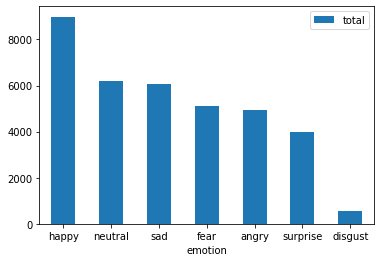

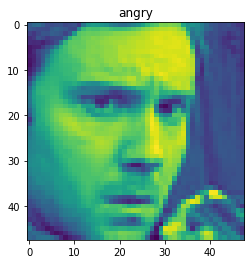

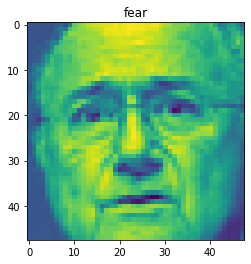

In [33]:
if (analisis==True):
    df = extractCheckData()
    countData(df)
    plt.figure()
    plotPhotos(df)

Ahora sabemos que existen 3 columnas:
- emotion: indica que expresion tiene la persona de la foto.
- pixels: la foto en pixeles.
- usage: el uso que se le da a dicha foto (Training/PublicTest/PrivateTest).
NOTA: usaremos posteriormente el 25% para test.

### Si se ha indicado entrenamos usando RandomForest

In [34]:
if (RandomForest==True):
    # llamamos a la funcion para obtener los datos del dataset
    X,Y = getData()
    # creamos variables de entrenamiento y validacion
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.25,random_state=0)
    # entrenamos el modelo con 150 arboles
    rf = RandomForestClassifier(n_estimators=150)
    rf.fit(x_train,y_train)

### Se entrena un modelo CNN o se carga uno que ya existe.

In [35]:
# comprobamos si existe un modelo guardado o no
if(model_saved==False):
    # solicitamos datos
    X_train, X_test, Y_train, Y_test = loadData()
    # definimos el modelo
    model = my_model7Batch()
    # hacemos fit con un batch de tamaño 32 y 20 epoch
    h = model.fit(x=X_train,     
            y=Y_train, 
            batch_size=32, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,Y_test),
            shuffle=True
            )
    # pasamos el modelo a json para almacenarlo
    model_json = model.to_json()
    with open("expresionsjsonMODELtestx.json", "w") as json_file:
        json_file.write(model_json)
    # almacenamos en formato h5
    model.save_weights("expressionsh5MODELtestx.h5")
    print("El modelo ha sido generado y almacenado con exito.")
    mostrar_resultados_entrenamiento = True
else:
    # el modelo ya existe y no hace falta entrenar la NN, por lo que cargamos el json
    json_file = open('expresionsjsonMODELtest4.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # cargamos el archivo h5
    model.load_weights("expressionsh5MODELtest4.h5")   
    # compilamos el modelo para poder usarlo
    adamOpt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adamOpt)
    print("El modelo ha sido cargado.")

El modelo ha sido cargado.


### Si se ha realizado un entrenamiento se muestran las gráficas de perdida y precisión.

In [36]:
if (mostrar_resultados_entrenamiento == True):
    plot_resultados_entrenamiento()

### Si se ha indicado, se muestra la matriz con los resultados.

Porcentaje de acierto CNN:  0.6006464556397682
Porcentaje de acierto Random Forest:  0.46845742309407046


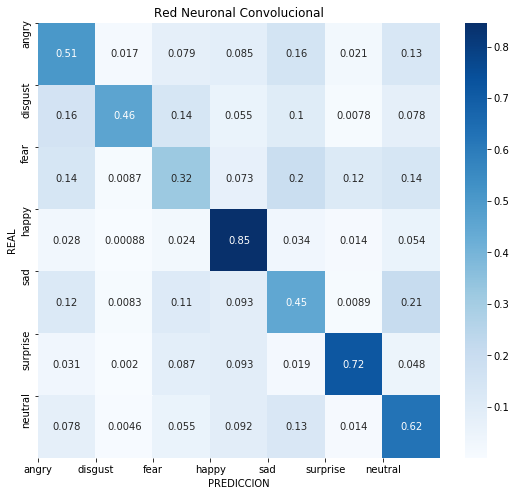

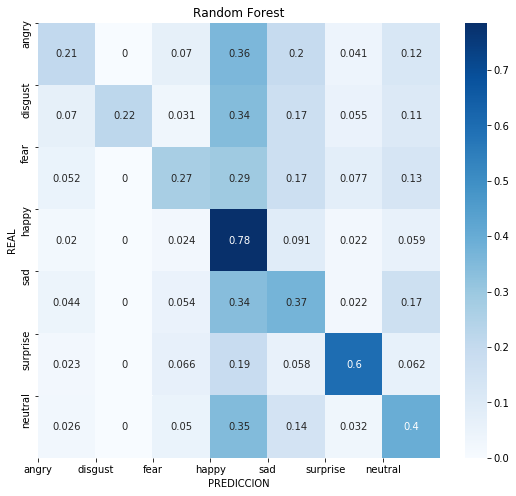

In [37]:
if (matrix==True):
    # llamamos a la funcion que pinta el porcentaje de acierto y la matriz
    my_matrix()   

### Peticion POST del lado del servidor.

In [38]:
app = Bottle()
@app.route("/getMood", method="POST")
def do_upload():
    
    foto = request.files["photo"]
    # usamos un archivo temporal para poder manipular la foto
    temporal = tempfile.TemporaryFile()
    foto.save(temporal)
    # es necesario que la foto tenga unas caracteristicas antes de ser mandada a la CNN, por ello primero se prepara
    imagen_lista = prepare_photo(Image.open(temporal))
    # realizamos la prediccion de la foto lista para poder ser interpretada por la CNN
    resultado = do_prediction(imagen_lista)
    # cerramos el archivo temporal
    temporal.close()
    
    print(resultado)
    
    return resultado

### Ejecutamos el servidor para que se puedan realizar peticiones.

In [39]:
run(app,host=ip, port=9004, debug=True)

Bottle v0.12.18 server starting up (using WSGIRefServer())...
Listening on http://192.168.1.39:9004/
Hit Ctrl-C to quit.



{'expressions': [{'mood': 'angry', 'probability': 0.011}, {'mood': 'disgust', 'probability': 0.002}, {'mood': 'fear', 'probability': 0.007}, {'mood': 'happy', 'probability': 0.95}, {'mood': 'sad', 'probability': 0.012}, {'mood': 'surprise', 'probability': 0.001}, {'mood': 'neutral', 'probability': 0.016}]}


192.168.1.33 - - [11/Jun/2020 17:57:26] "POST /getMood HTTP/1.1" 200 307


{'expressions': [{'mood': 'angry', 'probability': 0.044}, {'mood': 'disgust', 'probability': 0.003}, {'mood': 'fear', 'probability': 0.074}, {'mood': 'happy', 'probability': 0.435}, {'mood': 'sad', 'probability': 0.132}, {'mood': 'surprise', 'probability': 0.102}, {'mood': 'neutral', 'probability': 0.21}]}


192.168.1.33 - - [11/Jun/2020 17:57:31] "POST /getMood HTTP/1.1" 200 307


{'expressions': [{'mood': 'angry', 'probability': 0.057}, {'mood': 'disgust', 'probability': 0.007}, {'mood': 'fear', 'probability': 0.29}, {'mood': 'happy', 'probability': 0.167}, {'mood': 'sad', 'probability': 0.12}, {'mood': 'surprise', 'probability': 0.222}, {'mood': 'neutral', 'probability': 0.136}]}


192.168.1.33 - - [11/Jun/2020 17:57:37] "POST /getMood HTTP/1.1" 200 306


{'expressions': [{'mood': 'angry', 'probability': 0.012}, {'mood': 'disgust', 'probability': 0.002}, {'mood': 'fear', 'probability': 0.014}, {'mood': 'happy', 'probability': 0.857}, {'mood': 'sad', 'probability': 0.027}, {'mood': 'surprise', 'probability': 0.014}, {'mood': 'neutral', 'probability': 0.074}]}


192.168.1.33 - - [11/Jun/2020 17:57:42] "POST /getMood HTTP/1.1" 200 308


{'expressions': [{'mood': 'angry', 'probability': 0.011}, {'mood': 'disgust', 'probability': 0.0}, {'mood': 'fear', 'probability': 0.071}, {'mood': 'happy', 'probability': 0.125}, {'mood': 'sad', 'probability': 0.043}, {'mood': 'surprise', 'probability': 0.49}, {'mood': 'neutral', 'probability': 0.26}]}


192.168.1.33 - - [11/Jun/2020 17:57:48] "POST /getMood HTTP/1.1" 200 304


{'expressions': [{'mood': 'angry', 'probability': 0.015}, {'mood': 'disgust', 'probability': 0.007}, {'mood': 'fear', 'probability': 0.004}, {'mood': 'happy', 'probability': 0.4}, {'mood': 'sad', 'probability': 0.093}, {'mood': 'surprise', 'probability': 0.002}, {'mood': 'neutral', 'probability': 0.48}]}


192.168.1.33 - - [11/Jun/2020 17:57:52] "POST /getMood HTTP/1.1" 200 305
G:\Programs\Anaconda3\lib\site-packages\bottle.py:3139: ResourceWarning: unclosed <socket.socket fd=4500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.39', 9004)>
  pass
